### Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from pycoingecko import CoinGeckoAPI
import matplotlib.pyplot as plt
%matplotlib inline

### Fetch cryptocurrency data

In [21]:
cg = CoinGeckoAPI()

def fetch_crypto_data(market_cap_range):
    coins = cg.get_coins_markets(
        vs_currency='usd',
        order='market_cap_desc',
        per_page=250,
        page=1,
        sparkline=False,
        price_change_percentage='24h,7d,30d'
    )
    
    df = pd.DataFrame(coins)
    df = df[(df['market_cap'] >= market_cap_range[0]) & (df['market_cap'] <= market_cap_range[1])]
    return df

df = fetch_crypto_data((10000000, 500000000))

df.columns

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated,price_change_percentage_24h_in_currency,price_change_percentage_30d_in_currency,price_change_percentage_7d_in_currency
139,coinbase-wrapped-staked-eth,cbeth,Coinbase Wrapped Staked ETH,https://coin-images.coingecko.com/coins/images...,2643.960000,495024039,140,988770498,13825748.0,2663.070000,...,-39.06198,2024-03-12T00:21:42.892Z,1.036960e+03,154.79273,2022-11-09T23:45:43.665Z,None,2024-10-08T18:24:02.800Z,-0.458713,7.738868,-2.409427
140,true-usd,tusd,TrueUSD,https://coin-images.coingecko.com/coins/images...,0.996546,493892080,141,493892080,17202555.0,1.001000,...,-38.34969,2018-08-26T20:41:09.375Z,8.835500e-01,12.93287,2020-03-12T10:47:51.380Z,None,2024-10-08T18:24:08.941Z,-0.139300,-0.311678,-0.151174
141,terra-luna,lunc,Terra Luna Classic,https://coin-images.coingecko.com/coins/images...,0.000086,489704201,142,580801082,39414241.0,0.000091,...,-99.99993,2022-04-05T12:24:58.854Z,9.999670e-07,8483.83569,2022-05-13T02:34:40.340Z,None,2024-10-08T18:24:09.646Z,-3.219511,11.574048,-3.172329
142,jupiter-staked-sol,jupsol,Jupiter Staked SOL,https://coin-images.coingecko.com/coins/images...,149.930000,485830186,143,485830186,5565725.0,154.680000,...,-24.98370,2024-07-29T05:46:39.189Z,1.143200e+02,30.65398,2024-08-05T11:36:21.655Z,None,2024-10-08T18:23:50.965Z,-2.723358,12.267390,-2.384991
143,l2-standard-bridged-weth-base,weth,L2 Standard Bridged WETH (Base),https://coin-images.coingecko.com/coins/images...,2446.950000,484357992,144,484357992,529809518.0,2463.300000,...,-12.90693,2024-08-24T16:40:44.140Z,2.160500e+03,13.46339,2024-09-06T21:02:32.860Z,None,2024-10-08T18:23:56.665Z,-0.446459,7.372814,-2.358108


In [22]:
df.columns

Index(['id', 'symbol', 'name', 'image', 'current_price', 'market_cap',
       'market_cap_rank', 'fully_diluted_valuation', 'total_volume',
       'high_24h', 'low_24h', 'price_change_24h',
       'price_change_percentage_24h', 'market_cap_change_24h',
       'market_cap_change_percentage_24h', 'circulating_supply',
       'total_supply', 'max_supply', 'ath', 'ath_change_percentage',
       'ath_date', 'atl', 'atl_change_percentage', 'atl_date', 'roi',
       'last_updated', 'price_change_percentage_24h_in_currency',
       'price_change_percentage_30d_in_currency',
       'price_change_percentage_7d_in_currency'],
      dtype='object')

In [25]:
def engineer_features(df):
    df['volume_to_market_cap'] = df['total_volume'] / df['market_cap']
    df['circulating_supply_ratio'] = df['circulating_supply'] / df['total_supply']
    df['price_to_ath_ratio'] = df['current_price'] / df['ath']
    df['days_since_ath'] = (pd.Timestamp.utcnow() - pd.to_datetime(df['ath_date'])).dt.days
    df['volatility'] = df['high_24h'] - df['low_24h']
    return df

# Use this function after fetching data
df = engineer_features(df)

### Preprocess data for machine learning

In [26]:
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Preprocess data for machine learning
def preprocess_data(df):
    features = ['price_change_percentage_24h_in_currency', 'price_change_percentage_7d_in_currency', 'price_change_percentage_30d_in_currency', 'market_cap', 'total_volume']
    X = df[features]
    
    # Create a pipeline with imputer and scaler
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    X_processed = preprocessor.fit_transform(X)
    
    return X_processed

# Apply K-means clustering
def apply_kmeans(X, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    return clusters

### Identify potentially underpriced cryptocurrencies

In [27]:
def identify_underpriced(df, clusters):
    df['cluster'] = clusters
    
    # Calculate average price change for each cluster
    cluster_avg_change = df.groupby('cluster')['price_change_percentage_30d_in_currency'].mean()
    
    # Find the cluster with the lowest average price change
    underpriced_cluster = cluster_avg_change.idxmin()
    
    # Select cryptocurrencies from the underpriced cluster
    underpriced_coins = df[df['cluster'] == underpriced_cluster].sort_values('market_cap', ascending=True)
    
    return underpriced_coins[['id', 'symbol', 'name', 'current_price', 'market_cap', 'price_change_percentage_30d_in_currency']]

### Main function to run the analysis

In [28]:
X_scaled = preprocess_data(df)
clusters = apply_kmeans(X_scaled)
underpriced_coins = identify_underpriced(df, clusters)

# Run the analysis
print("Potentially underpriced low/medium cap cryptocurrencies:")
underpriced_coins

Potentially underpriced low/medium cap cryptocurrencies:


,id,symbol,name,current_price,market_cap,price_change_percentage_30d_in_currency
183,dogs-2,dogs,Dogs,0.000708,366814759,-25.024937
180,constitutiondao,people,ConstitutionDAO,0.074947,379725066,44.558783
157,book-of-meme,bome,BOOK OF MEME,0.006386,440672116,6.818140
143,l2-standard-bridged-weth-base,weth,L2 Standard Bridged WETH (Base),2446.950000,484357992,7.372814


### Visualize the results

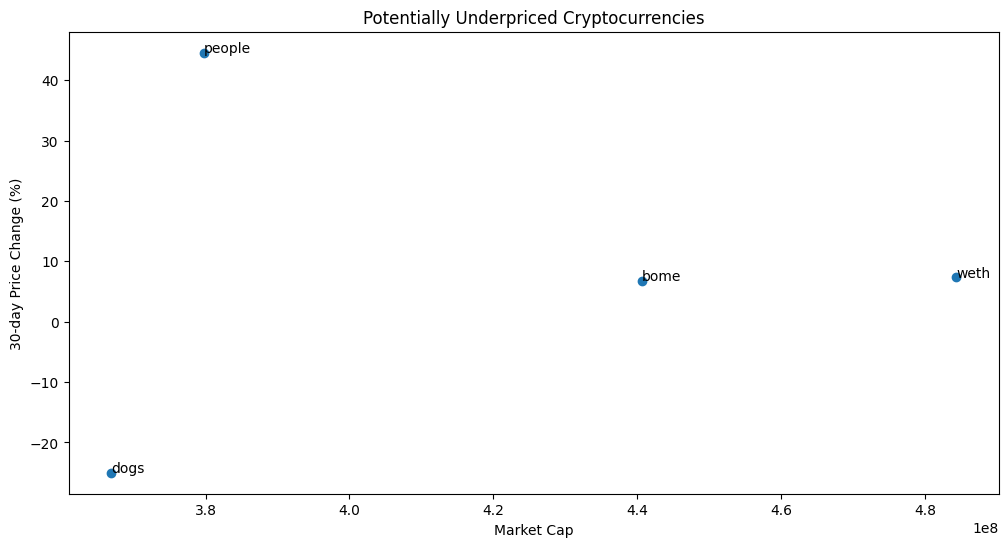

In [29]:
plt.figure(figsize=(12, 6))
plt.scatter(underpriced_coins['market_cap'], underpriced_coins ['price_change_percentage_30d_in_currency'])
plt.xlabel('Market Cap')
plt.ylabel('30-day Price Change (%)')
plt.title('Potentially Underpriced Cryptocurrencies')
for i, txt in enumerate(underpriced_coins['symbol']):
    plt.annotate(txt, (underpriced_coins['market_cap'].iloc[i], underpriced_coins['price_change_percentage_30d_in_currency'].iloc[i]))
plt.show()